In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL

import collections
# import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
import clip_structure.CLIP.clip as clip
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [2]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )


    def forward(self, x):
        '''Forward pass'''
        deltas = self.layers(x)
        return x.flatten() + 0.1 * deltas

def get_initial_points(path_svg, target_, device):
    target = torch.from_numpy(skimage.io.imread(target_)).to(torch.float32) / 255.0
    # target = target.pow(gamma)
    target = target.to(pydiffvg.get_device())
    target = target.unsqueeze(0)
    target = target.permute(0, 3, 1, 2) # NHWC -> NCHW
    
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path



def render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=torch.tensor(1.5), is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device, canvas_width=canvas_width, canvas_height=canvas_height)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    plt.imshow(img.cpu().numpy())
    plt.show()
    return points_vars

    
def optimize_through_net(target, points_vars, mlp, mlp_opt, loss_clip, device, canvas_size=224, num_strokes=32, num_cp=4, num_iter=10, print_interval=10):    
    for t in range(num_iter):
        mlp_opt.zero_grad()
        points = mlp(points_vars)
        img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
        if t % print_interval == 0:
            print('iteration:', t)
            plt.imshow(img.cpu().detach().numpy())
            plt.show()
            plt.close()
            
        img = img[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")
        # print(loss_clip_)
        loss = sum(list(loss_clip_.values()))
        
        if t % print_interval == 0:
            print('render loss:', loss.item())
    
        loss.backward()
        mlp_opt.step()
    
    points = mlp(points_vars)
    img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
    return img

/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


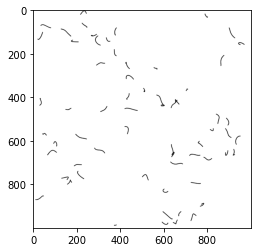

torch.Size([1, 64, 4, 2])
iteration: 0


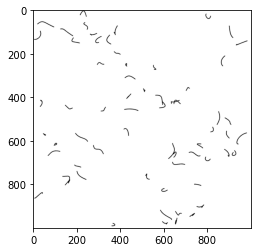

outputs torch.Size([1, 3, 1000, 1000])
inputs torch.Size([1, 3, 1000, 1000])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
render loss: 0.05133056640625


/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/miniconda/envs/habitat/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


iteration: 1


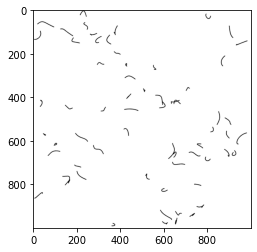

outputs torch.Size([1, 3, 1000, 1000])
inputs torch.Size([1, 3, 1000, 1000])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
render loss: 0.05133056640625
iteration: 2


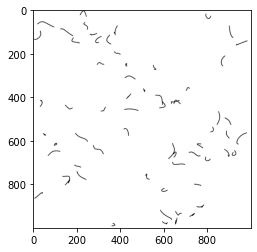

outputs torch.Size([1, 3, 1000, 1000])
inputs torch.Size([1, 3, 1000, 1000])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
render loss: 0.051300048828125
iteration: 3


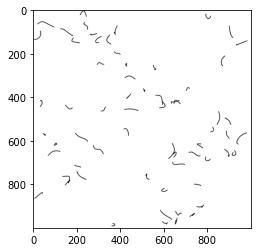

outputs torch.Size([1, 3, 1000, 1000])
inputs torch.Size([1, 3, 1000, 1000])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
render loss: 0.05133056640625
iteration: 4


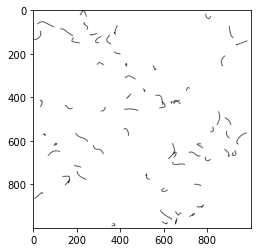

outputs torch.Size([1, 3, 1000, 1000])
inputs torch.Size([1, 3, 1000, 1000])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
calculate_self_sim torch.Size([1, 3, 1000, 1000])
transformer_first_blocks_forward
torch.Size([1, 3, 1000, 1000])
conv torch.Size([1, 768, 31, 31])
reshape torch.Size([1, 768, 961])
permute torch.Size([1, 961, 768])
cat torch.Size([1, 962, 768])
positional_embedding torch.Size([1, 962, 768])
ln_pre torch.Size([1, 962, 768])
permute torch.Size([962, 1, 768])
resblocks [:-1] torch.Size([962, 1, 768])
render loss: 0.051300048828125


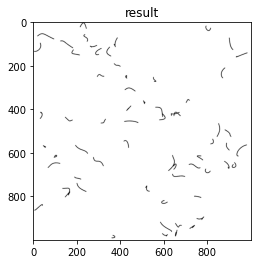

In [3]:
from torchvision import transforms as T

random.seed(0)
np.random.seed(0)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter1000.svg"
path_svg = "/home/vinker/dev/background_project/experiements/05_29_image_divide/semi-complex_ViT_l4_32s/semi-complex_ViT_l4_32s_seed1000_best.svg"
target_ = "/home/vinker/dev/input_images/video_sketching/swan_texture_orig_back.png"
target = Image.open(target_)

# canvas_size=224
canvas_size=target.size[0]
num_strokes=64
num_cp=4

target, mask = get_target(target_, device, image_scale=canvas_size)
points_vars = get_initial_points_mask(torch.ones((1,canvas_size,canvas_size)), num_strokes, device, canvas_width=canvas_size, canvas_height=canvas_size)
# points_vars = get_initial_points(path_svg, target_, device) # list of tensors

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
print(points_vars.shape)
# return
points_vars = (points_vars) / canvas_size
points_vars = 2*points_vars-1

mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
mlp_opt = torch.optim.Adam(mlp.parameters(), lr=1e-4)

model = clip.load("ViT-B/32", device=device)[0]
model = model.eval().requires_grad_(False)
# aug = T.Compose([T.RandomResizedCrop(
                # 224, scale=(0.4, 1.0), ratio=(1.0, 1.0)),])
preprocess = T.Compose([
    # T.Resize(224),  # CLIP was trained on 224x224, but we can resize to arbitrary resolution
    T.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
    )])

def calculate_structure_loss(model, outputs, inputs):
    print("outputs", outputs.shape)
    print("inputs", inputs.shape)
    # sketch_augs, img_augs = [preprocess(outputs)], [
    #         preprocess(inputs)]
    # for i in range(4):
    #     augmented_pair = preprocess(aug(torch.cat([outputs, inputs])))
    #     sketch_augs.append(augmented_pair[0].unsqueeze(0))
    #     img_augs.append(augmented_pair[1].unsqueeze(0))
    # outputs = torch.cat(sketch_augs, dim=0)
    # inputs = torch.cat(img_augs, dim=0)
    outputs = preprocess(outputs)
    inputs = preprocess(inputs)
    with torch.no_grad():
        target_self_sim = model.calculate_self_sim(inputs)
    current_ss = model.calculate_self_sim(outputs)
    loss = torch.nn.MSELoss()(current_ss, target_self_sim)
    return loss

num_iter=5
print_interval=1

for t in range(num_iter):
    mlp_opt.zero_grad()
    points = mlp(points_vars)
    img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=canvas_size, canvas_height=canvas_size)
    if t % print_interval == 0:
        print('iteration:', t)
        plt.imshow(img.cpu().detach().numpy())
        plt.show()
        plt.close()

    img = img[:, :, :3]
    # Convert img from HWC to NCHW
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW

    # sketch, target
    loss_clip_ = calculate_structure_loss(model, img, target)#loss_clip(img, target, mode="train")
    # print(loss_clip_)
    loss = loss_clip_
    # loss = sum(list(loss_clip_.values()))

    if t % print_interval == 0:
        print('render loss:', loss.item())

    loss.backward()
    mlp_opt.step()

points = mlp(points_vars)
img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=canvas_size, canvas_height=canvas_size)
# return img



# im = optimize_through_net(target, points_vars, mlp, optimizer, loss_clip, device, canvas_size=224, num_strokes=num_strokes, num_cp=4,num_iter=1001, print_interval=50)
plt.imshow(img.detach().cpu().numpy())
plt.title("result")
plt.show()